# Credit Card Fraud with Tensorflow. 
Nathan Brasher - 5.15.20

This notebook examines techniques to improve modeling in the [Kaggle credit card fraud](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set. In developing this model, I borrowed from the examples in [this notebook](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets) also stored on Kaggle.

This notebook consists of 3 main sections:
1. EDA
1. Data cleaning and preparation
1. Model fitting
1. Model deployment

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
# Common random seed
seed = 42

In [3]:
# Install additional packages for s3 download, SMOTE
!pip install s3fs imblearn

In [4]:
# Read project data
df = pd.read_csv('s3://udacity-project-fraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 1. Exploratory Data Analysis  

Detail TDB...

In [5]:
# The data contains 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Only 0.17% of the data set is fraudulent


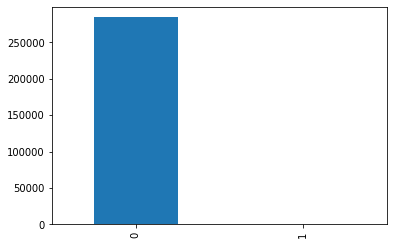

In [6]:
# The data set is heavily imbalanced
print('Only {:.2f}% of the data set is fraudulent'.format(
    100*len(df[df['Class'] == 1]) / len(df)
))

df['Class'].value_counts().plot.bar()
plt.show()

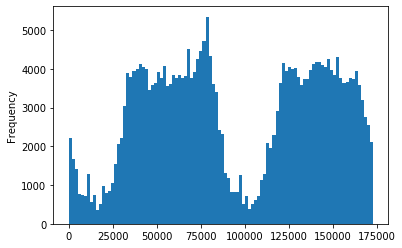

In [7]:
# Transactions are highly cyclical over time
df['Time'].plot.hist(bins=100)
plt.show()

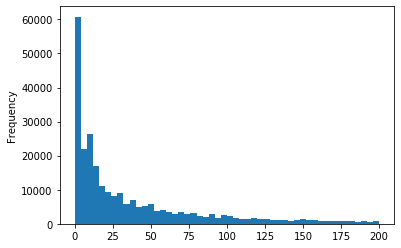

There is a long tail with 28,837 transactions over $200
The maximum transaction is $25,691.16 


In [8]:
# Transaction amount has a long tail with the majority less than $200
df[df['Amount'] < 200]['Amount'].plot.hist(bins=50)
plt.show()

print('There is a long tail with {:,} transactions over $200'.format(
    len(df[df['Amount'] > 200])))
print('The maximum transaction is ${:,.2f} '.format(
    df['Amount'].max()))

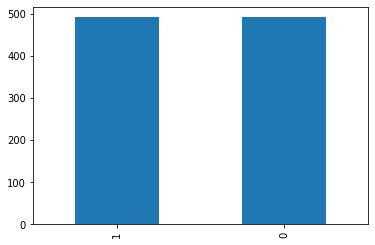

In [9]:
# To compare correlations of features, randomly undersample a balanced dataset
n_fraud = len(df[df['Class'] == 1])

balanced = pd.concat([df[df['Class'] == 1], 
                      df[df['Class'] == 0].sample(n_fraud)], 
                     ignore_index=True)

balanced['Class'].value_counts().plot.bar()
plt.show()

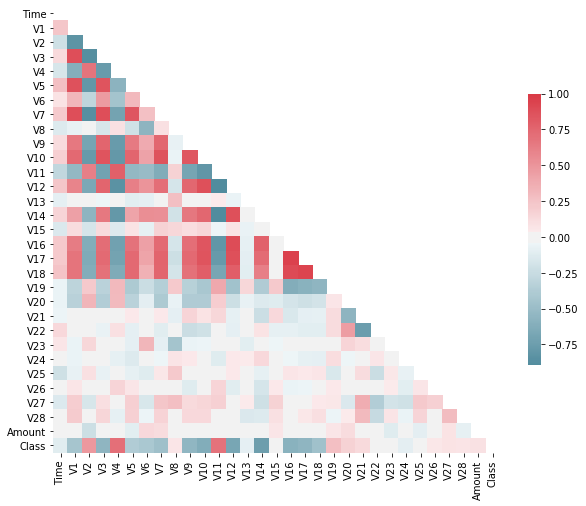

In [10]:
# Compute the correlation matrix
corr = balanced.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .5})
plt.show()

#### Feature distribution
Invetigation of feature distribution indicates that several features appear to be good distinguishers of fraud and non-fraud. In particular V4, V10, V11, V12, V14 and V17 appear to show sharp distinctions - which broadly aligns with the pairwise correlations above.

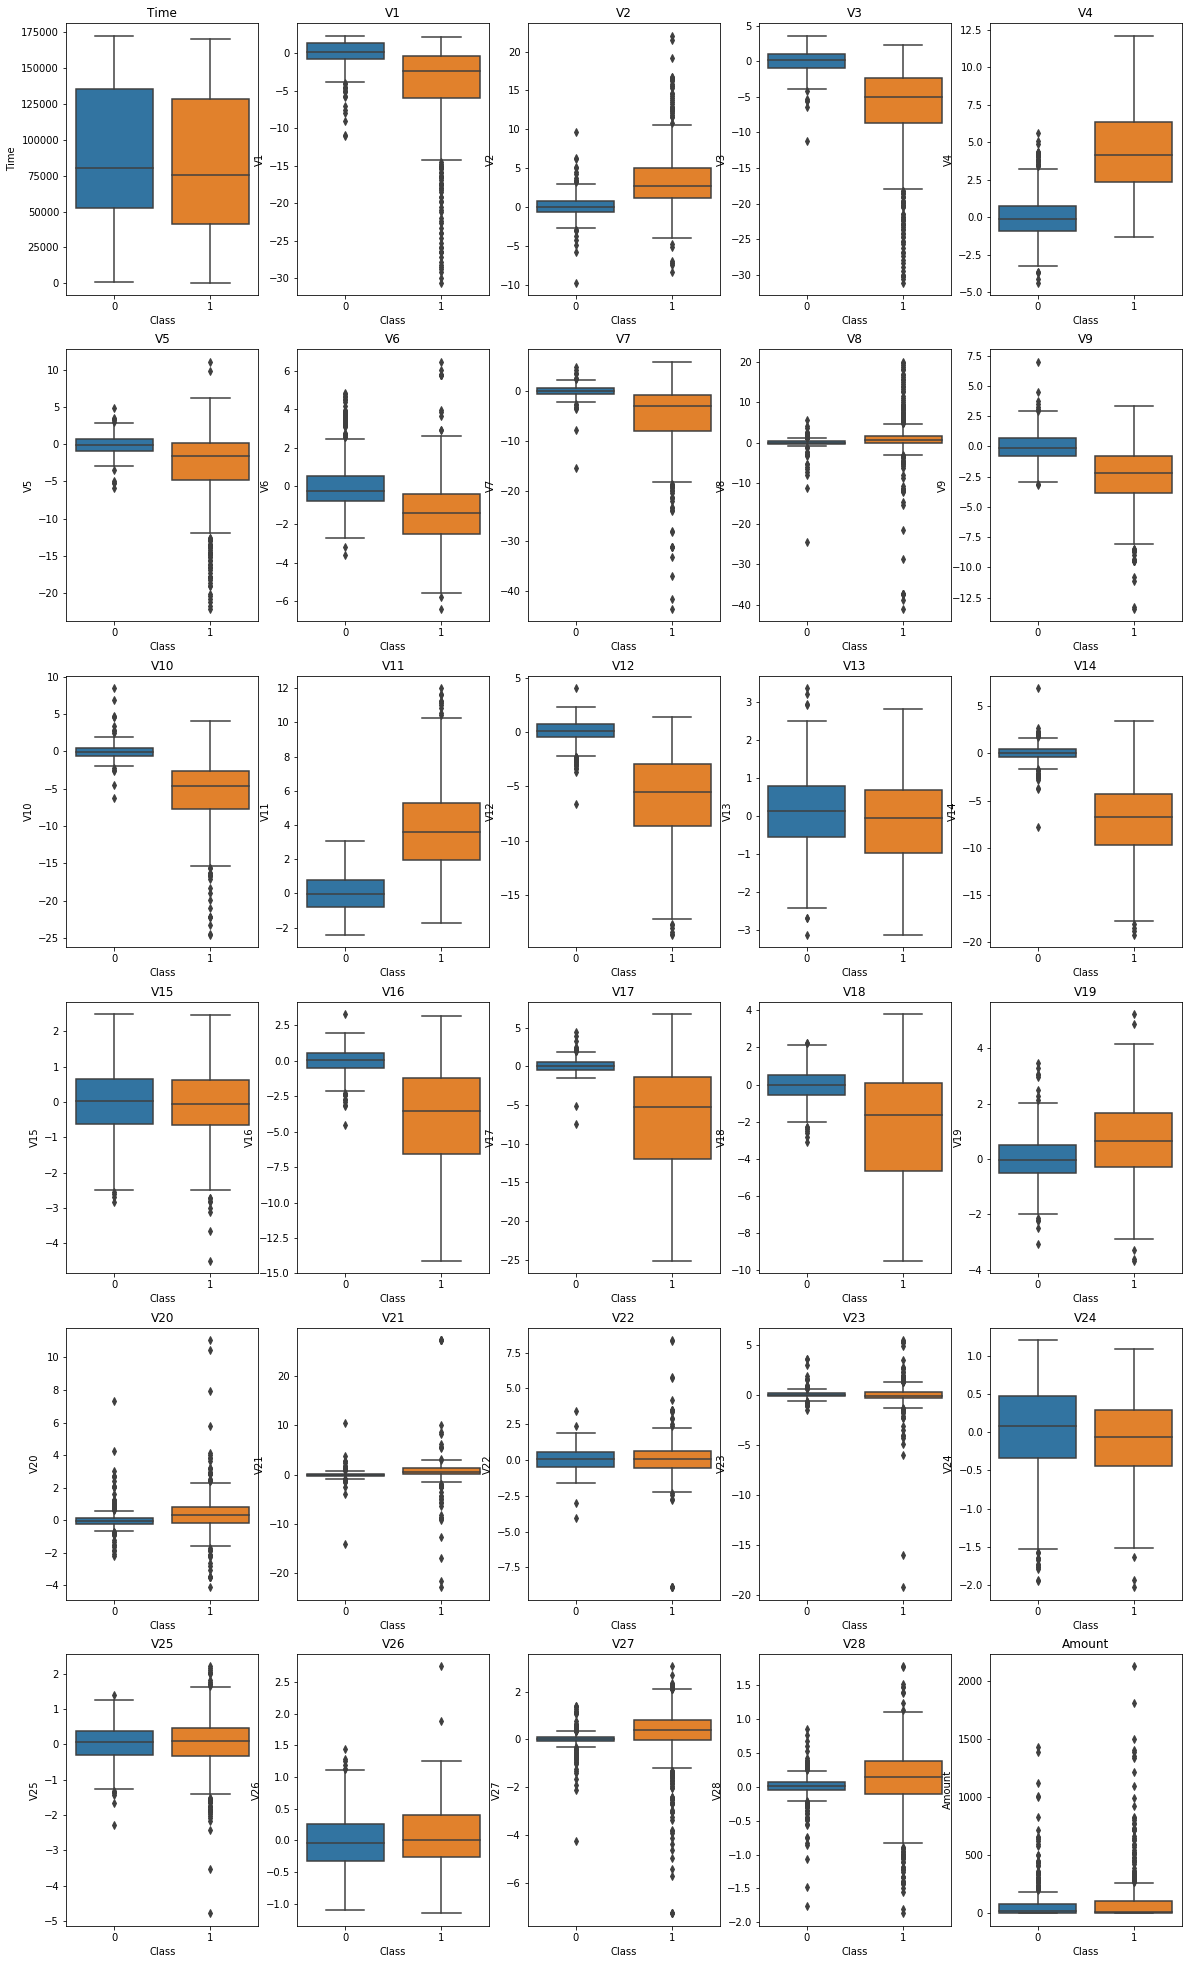

In [11]:
# Check distribution of each feature in fraudulent and non-fraudulent data
feature_cols = balanced.columns.to_list()
feature_cols.remove('Class')

ncols = 5
f, axes = plt.subplots(nrows=(len(feature_cols) // ncols), 
                       ncols=ncols, 
                       figsize=(20, 35))

for i, c in enumerate(feature_cols):
    sns.boxplot(x='Class', y=c, data=balanced, ax=axes[i//ncols, i%ncols])
    axes[i//ncols, i%ncols].set_title(c)

plt.show()

## 2. Data preparation and cleaning. 

From the EDA above, its apparent that each feature has differing scales, and also several outliers depending on the feature. Before running it through the Keras NN inteface, we scale the data using an SKLearn robust scaler to avoid outlier interference.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis=1), df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=seed,
                                                    stratify=df['Class'], 
                                                    shuffle=True)

### Outlier removal

From our EDA above V4, 10, 12 and 14 appear to be good distinguishing features between Fraud and non-fraudulent transactions. All of them also have significant outliers (> 1.5 IQR) that could affect predictive power. In order to improve the models ability to distinguish fraud-from non-fraud we want to remove these outlier values

In [13]:
# Remove outliers from train data only
cols_to_clean = ['V4', 'V10', 'V12', 'V14']

fraud = X_train[y_train == 1]

outlier_ix = set()

for c in cols_to_clean:
    q25 = np.percentile(fraud[c].values, 25)
    q75 = np.percentile(fraud[c].values, 75)
    iqr = q75 - q25
    lower_bound, upper_bound = q25 - 1.5*iqr, q75 + 1.5*iqr

    col_outliers = [i for i, v in fraud[c].iteritems() 
                    if v < lower_bound or v > upper_bound]
    outlier_ix.update(col_outliers)
    
print(f'{len(outlier_ix)} points to remove')

X_train_clean = X_train.loc[~X_train.index.isin(outlier_ix), :]
y_train_clean = y_train.loc[~X_train.index.isin(outlier_ix)]

28 points to remove


### Sample balancing
As we saw earlier in the notebook, the input data is highly imbalanced, with 99.8% of transactions non-fraudulent, and only ~0.2% of trasnactions labeled as fraud. Once we've removed outliers above, we need to re-balance the data. In the cells below we use the Synthetic Minority Oversample TEchnique to balance the dataset without grossly reducing the train data size through under-sampling. More on the `imblearn` SMOTE can be found [here](https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#smote-adasyn).

In [14]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=seed)
X_train_sm, y_train_sm = sm.fit_sample(X_train_clean, y_train_clean)

50.00% of the re-sampled data set is fraudulent


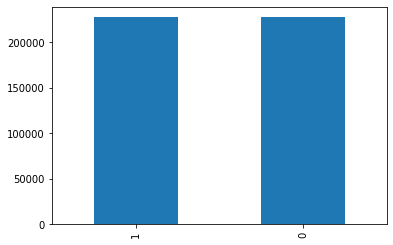

In [15]:
# Check levels in the re-sampled data
print('{:.2f}% of the re-sampled data set is fraudulent'.format(
    100*(y_train_sm == 1).sum() / len(y_train_sm)
))

y_train_sm.value_counts().plot.bar()
plt.show()

### Variable scaling

Finally, once the data has been cleaned and re-sampled it must be scaled in order to effectively train the TensorFlow model below. Importantly the test dataset below must be scaled with the same method

In [16]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

X_train_scaled = pd.DataFrame(index=X_train_sm.index, 
                              columns=X_train_sm.columns, 
                              data=rs.fit_transform(X_train_sm))
X_test_scaled = rs.transform(X_test)

### Save cleaned and re-sampled data for training

Finally once, the data is completely ready for training, we save to `data_dir` local image, in order to use sagemaker to upload the data to S3 for training later on

In [17]:
data_dir = 'data'
pd.concat([X_train_scaled, y_train_sm], axis=1).to_csv(
    os.path.join(data_dir, 'train.csv'), 
    index=False)

# 3. Model Fitting

Now that data is complete and ready for training we can train using a Sagemaker Tensorflow image. The custom training script I created is below. Critically, in order to properly save the model, you must make sure to use `tf.keras` and not standalone `keras` functionality.

The neural network architecture we create is fairly simple, in this case CPU training is adequate for training

In [18]:
!pygmentize train/train.py

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, Dense
import sagemaker_containers
import tensorflow as tf
import pandas as pd
import numpy as np
import argparse
import pickle
import json
import sys
import os

def _get_train_data(training_dir):
    '''Retrieve training data'''
    train_data = pd.read_csv(os.path.join(training_dir, "train.csv"))

    X = train_data.drop(['Class'], axis=1)
    y = train_data['Class']

    return X, y

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Training Parameters
    parser.add_argument('--batch-size', type=int, default=1000, metavar='B',
                        help='input batch size for training (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='E',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)

In [19]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'capstone'

role = sagemaker.get_execution_role()

In [20]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [21]:
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    entry_point="train.py",
    source_dir="train",
    role=role,
    framework_version='2.1.0',
    py_version='py3',
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    hyperparameters={
        'epochs': 10,
})

In [22]:
estimator.fit({'training': input_data})

2020-05-15 20:55:30 Starting - Starting the training job...
2020-05-15 20:55:32 Starting - Launching requested ML instances......
2020-05-15 20:56:36 Starting - Preparing the instances for training...
2020-05-15 20:57:18 Downloading - Downloading input data...
2020-05-15 20:57:53 Training - Downloading the training image..2020-05-15 20:58:09,682 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-05-15 20:58:09,689 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 20:58:09,978 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 20:58:09,994 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 20:58:10,008 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-05-15 20:58:10,018 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs

# 4. Model Deployment  

The final step is to deploy our trained model, and test it on the original un-filtered data. The test data has not been filtered for outliers, and it remains heavily imbalanced (~0.2% fradulent). In the example below we acheive an ROC-AUC score of 0.97. Our deployed model caught 90% of fraud, while mislabeling 284 cases as fraud, when they were actually legit for a recall of ~24%. While that may seem low, given the imbalanced nature of our dataset consider that the true negative rate is 56580 / (56580 + 284) or ~99.5%. Meaning we correctly labeled fraud as fraud ~90% of the time, and non-fraud as non-fraud 99.5%.

In [23]:
predictor = estimator.deploy(initial_instance_count=1, 
                             instance_type='ml.t2.medium')

-------------!

In [24]:
predictor.endpoint

'tensorflow-training-2020-05-15-20-55-29-763'

In [25]:
# Use endpoint to predict results
# Predict in batches to avoid broken pipe errors
batches = np.array_split(X_test_scaled, 10)

y_proba = np.array([])
for batch in batches:
    preds = predictor.predict(batch)['predictions']
    y_proba = np.append(y_proba, [x[0] for x in preds])

Test Imbalanced AUC: 0.9732803222583349
[[56666   198]
 [   11    87]]


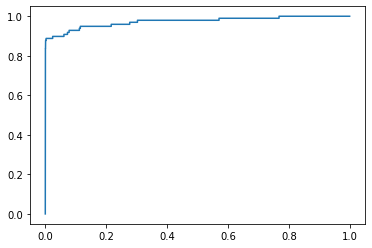

In [26]:
from sklearn import metrics
y_pred = np.around(y_proba, 0)

print(f'Test Imbalanced AUC: {metrics.roc_auc_score(y_test, y_proba)}')

print(metrics.confusion_matrix(y_test, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.show()

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.31      0.89      0.45        98

    accuracy                           1.00     56962
   macro avg       0.65      0.94      0.73     56962
weighted avg       1.00      1.00      1.00     56962



Finally, when finished clean up the model endpoint

In [28]:
predictor.delete_endpoint()